In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
try:
    from brokenaxes import brokenaxes
except Exception:
    %pip install brokenaxes
finally:
    from brokenaxes import brokenaxes
import matplotlib.ticker as ticker
# import seaborn as sns
from matplotlib.gridspec import GridSpec
from glob import glob
from matplotlib.patches import Patch
from matplotlib.ticker import ScalarFormatter


In [11]:
def load_data(QUANTITY):
    files = glob(f"random_env_pretrain/{QUANTITY}_*.csv")
    exp_data_pretrain = pd.concat(pd.read_csv(file) for file in files)
    exp_data_pretrain = exp_data_pretrain.sort_values(by='steps')
    exp_data_pretrain["steps"] *= len(files)

    # Crop the PRETRAIN data to start at 200k steps and end at 15M steps
    # I don't like of the data behaves at the very beginning and at the very end
    exp_data_pretrain = exp_data_pretrain[(exp_data_pretrain['steps'] >= 250e3) & (exp_data_pretrain['steps'] <= 12e6)]
    
    
    files = glob(f"{QUANTITY}_*.csv")
    exp_data_finetune = pd.concat(pd.read_csv(file) for file in files)
    exp_data_finetune = exp_data_finetune.sort_values(by='steps')
    exp_data_finetune["steps"] *= len(files)
    exp_data_finetune = exp_data_finetune[(exp_data_finetune[QUANTITY] >= -25)] # Remove outliers
    return exp_data_pretrain, exp_data_finetune

In [67]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot(exp_data_pretrain, exp_data_finetune, QUANTITY, BOXPLOT_SIZE, **kwargs):
    # Data for performance plots
    pretrain_data = exp_data_pretrain.copy()
    finetune_data = exp_data_finetune.copy()
    finetune_data["steps"] += pretrain_data["steps"].iloc[-1]  # Shift finetune steps

    sim_scores = pretrain_data[QUANTITY]
    real_scores = finetune_data[QUANTITY]

    # Compute exponentially weighted moving averages
    alpha = 0.01
    sim_ewma = pd.Series(sim_scores).ewm(alpha=alpha).mean().tolist()
    real_ewma = pd.Series(real_scores).ewm(alpha=alpha).mean().tolist()

    # Compute standard deviations for shaded error bars
    sim_std = (pd.Series(sim_scores).rolling(window=50).std() / 2).tolist()
    real_std = (pd.Series(real_scores).rolling(window=50).std() / 2).tolist()

    # Define consistent colors
    sim_color = "black"
    real_env_color = "#2a9d8f"  # Teal for the real environment
    grey_shade = "grey"  # Neutral grey for simulation shading

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot simulation line and standard deviation
    ax.plot(pretrain_data['steps'], sim_ewma, label='Simulation', color=sim_color, linewidth=2)
    ax.fill_between(pretrain_data['steps'],
                    [max(0, ew - std) for ew, std in zip(sim_ewma, sim_std)],
                    [min(1, ew + std) for ew, std in zip(sim_ewma, sim_std)],
                    color=grey_shade, alpha=0.3)

    # Plot real environment line and standard deviation
    ax.plot(finetune_data['steps'], real_ewma, label='Unknown Environment', color=real_env_color, linewidth=2)
    ax.fill_between(finetune_data['steps'],
                    [max(0, ew - std) for ew, std in zip(real_ewma, real_std)],
                    [min(1, ew + std) for ew, std in zip(real_ewma, real_std)],
                    color=real_env_color, alpha=0.2)

    # Highlight the transition point
    transition_point = pretrain_data['steps'].iloc[-1]
    ax.axvline(x=transition_point, color='red', linestyle='--', linewidth=1.5, label='Transition Point')

    # Add a boxplot or violin plot
    boxplot_position = transition_point + (BOXPLOT_SIZE * transition_point)
    boxplot_width = BOXPLOT_SIZE * transition_point

    if "use_violin" in kwargs and kwargs["use_violin"]:
        # Violin plot case with matching teal color
        parts = ax.violinplot([real_scores], positions=[boxplot_position], widths=boxplot_width,
                              showmeans=False, showmedians=True)

        # Set body color
        for pc in parts['bodies']:
            pc.set_facecolor(real_env_color)  # Consistent teal color for the body
            pc.set_edgecolor("black")  # Black boundary for the violin
            pc.set_linewidth(1.5)
            pc.set_alpha(0.6)

        # Update the bar color for medians and quartiles to black
        if 'cmeans' in parts:
            parts['cmeans'].set_color("black")  # Black for means
        if 'cbars' in parts:
            parts['cbars'].set_color("black")  # Black for bars (quartiles)
        if 'cmedians' in parts:
            parts['cmedians'].set_color("black")  # Black for medians
        if 'cmins' in parts:
            parts['cmins'].set_color("black")  # Black for min lines
        if 'cmaxes' in parts:
            parts['cmaxes'].set_color("black")  # Black for max lines

    else:
        # Boxplot case
        ax.boxplot([real_scores], positions=[boxplot_position], widths=boxplot_width,
                   patch_artist=True, boxprops=dict(facecolor=real_env_color, color='black'),
                   showfliers=False)

    # Extend x-axis limits to avoid cutting off
    max_steps = finetune_data['steps'].iloc[-1] + boxplot_width * 2
    ax.set_xlim(0, max_steps)

    # Convert x-axis to millions
    ax.set_xticks(np.linspace(0, max_steps, 6))
    ax.set_xticklabels([f"{int(x / 1e6)}M" for x in np.linspace(0, max_steps, 6)])
    ax.set_xlabel('Steps (Millions)')
    ax.set_ylabel('Performance Metric')

    # Title and legend
    # ax.set_title('RL Performance: Simulation to Real Environment')

    # Move legend to the bottom-right corner before the transition
    ax.legend(loc='lower right', frameon=False, bbox_to_anchor=(0.8, 0.1))  # Adjusted legend position

    # Save and show with high resolution
    plt.tight_layout()
    plt.savefig(f"plots/{kwargs.get('name', 'journal_plot')}.png", dpi=300)  # Save at 300 dpi
    plt.show()


def load_and_plot(QUANTITY, BOXPLOT_SIZE, **kwargs):
    exp_data_pretrain, exp_data_finetune = load_data(QUANTITY)
    plot(exp_data_pretrain, exp_data_finetune, QUANTITY, BOXPLOT_SIZE, **kwargs)
    plt.show()

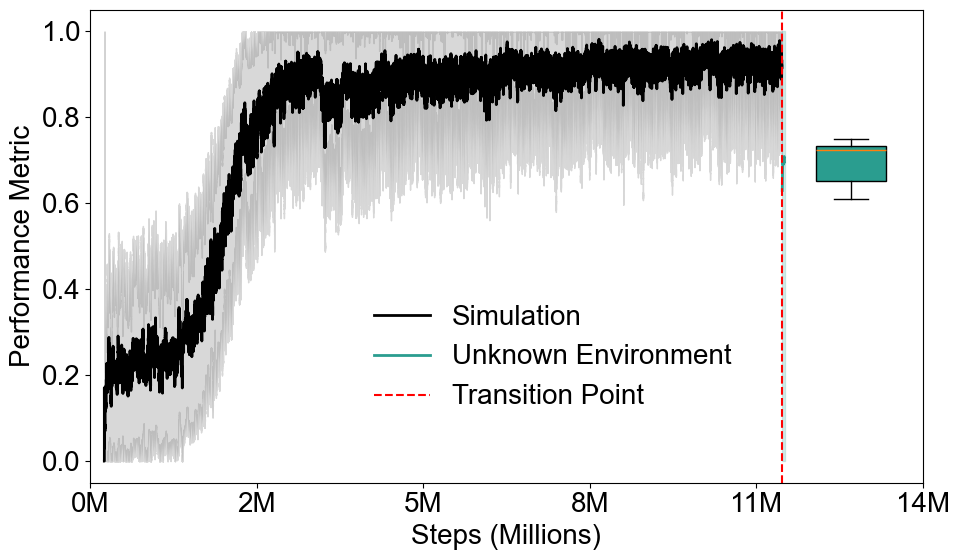

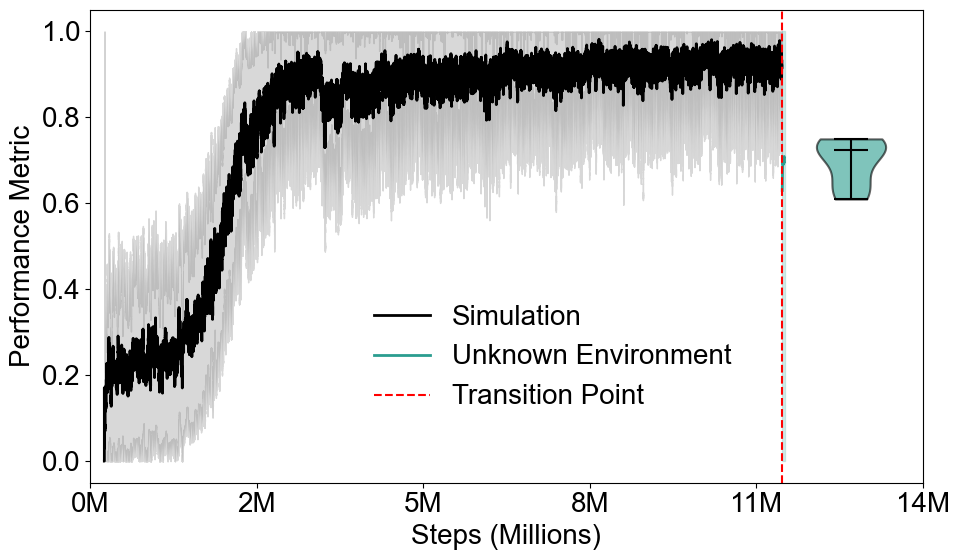

In [68]:
QUANTITY = 'rate_target_reached' # 'reward' or 'rate_target_reached'
BOXPLOT_SIZE = 0.1

load_and_plot(QUANTITY, BOXPLOT_SIZE, name='rate_target_plot')
load_and_plot(QUANTITY, BOXPLOT_SIZE, name='rate_target_plot_violin', use_violin=True)

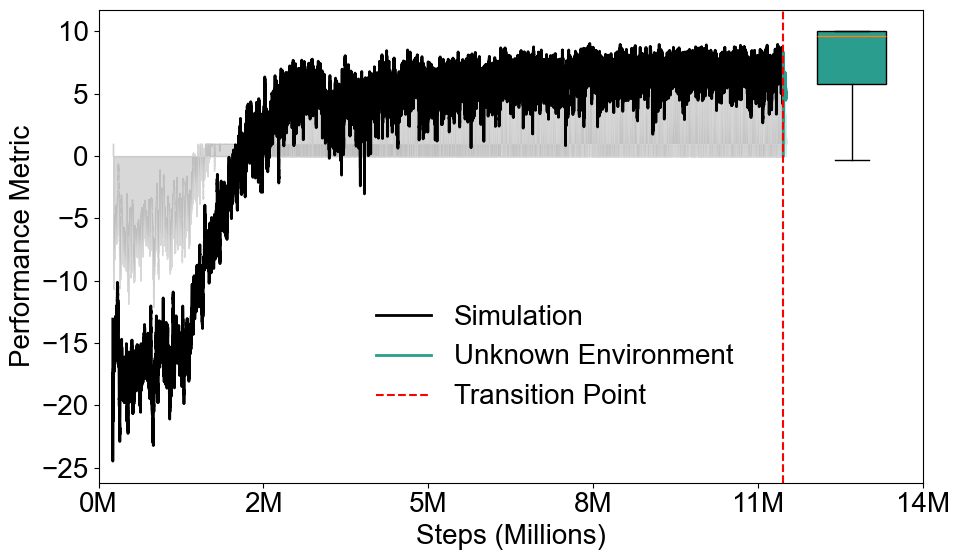

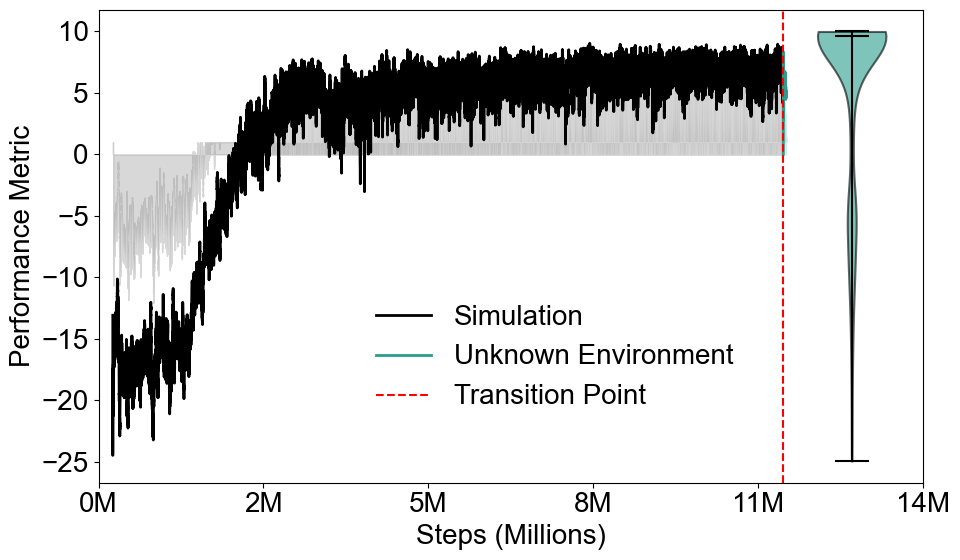

In [69]:
load_and_plot('reward', BOXPLOT_SIZE, name='reward')

load_and_plot('reward', BOXPLOT_SIZE, use_violin=True, name='reward_violin')